In [1]:
from einops import rearrange
import copy
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import torch
torch.cuda.set_device(1)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from pdb import set_trace
import matplotlib.pyplot as plt
from torch import nn
from x_transformers import  Encoder, Decoder
from x_transformers.autoregressive_wrapper import exists
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from fastai.vision.all import BCEWithLogitsLossFlat
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from fastprogress.fastprogress import master_bar, progress_bar
import os
from timm import create_model
import random
from tqdm import tqdm


from torch import Tensor
import torch.nn.functional as F
from typing import Tuple
import pickle
import timm

In [2]:
class CFG:
    bs = 64
    nw = 4
    model_name = "swin_large_patch4_window12_384"
    lr = 1e-4
    wd = 1e-4
    epoch = 12
    warmup_pct = 0.1
    num_classes = 1
    dropout_rate = 0.3
    folder = "EXP_200_BASELINE_CASHE_V3"
    mixup=False
    exp_name = f"{folder}_{model_name}"

In [3]:
def get_snr(left, right, df):
    df_ = pd.concat([df.query(f"snr>{left} & snr<{right}"), df.query("snr==0")])
    return df_


def generate_report(df):
    val_df_eval = df.copy()

    roc_100 = roc_auc_score(val_df_eval["target"], val_df_eval["pred"])

    roc_25_50 = roc_auc_score(
        get_snr(30, 50, val_df_eval)["target"], get_snr(30, 50, val_df_eval)["pred"]
    )

    return {
        "roc_all": roc_100,
        "roc_30_50": roc_25_50,

    }



In [4]:
def time_mask(spec, T=10):
    cloned = spec.clone().detach()
    len_spectro = cloned.shape[2]
    num_masks = np.random.randint(3, 8)
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        cloned[:, :,t_zero:mask_end] = 0
    return cloned




def freq_mask(spec, F=30):
    cloned = spec.clone().detach()
    num_mel_channels = cloned.shape[1]
    num_masks = np.random.randint(3, 8)
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        cloned[:, f_zero:mask_end, :] = 0
    
    return cloned

In [5]:
def read_pkl(filename):   
    with open(filename, 'rb') as file1: 
        k = pickle.load(file1)
        h1 = k["H1"]['spectrogram']
        l1 = k["L1"]['spectrogram']
        h1_timestamp = k["H1"]['timestamps']
        l1_timestamp = k["L1"]['timestamps']
        freq = k['frequency']
        
    data_dict = {"sft" : np.stack([h1[:, :4096], l1[:, :4096]]), 
                 "timestamps": {"H1": h1_timestamp, 
                                    "L1": l1_timestamp}}
    return data_dict

In [6]:
class Upsample(nn.Module):
    def __init__(self, in_channels, target_size, with_conv=True):
        super().__init__()
        self.with_conv = with_conv
        self.target_size = target_size
        if self.with_conv:
            self.conv = torch.nn.Conv2d(
                in_channels, in_channels, kernel_size=3, stride=1, padding=1
            )

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, size=self.target_size, mode="bilinear")
        if self.with_conv:
            x = self.conv(x)
        return x


class CustomHybdridEmbed(nn.Module):
    def __init__(
        self,
        decoder_proj_conv,
        channel_in=2,
        encoder_name="inception_v4",
        encoder_out_layer_num=[2],
        transformer_original_input_size=(1, 3, 224, 224),
    ):
        super().__init__()
        self.encoder = timm.create_model(
            encoder_name,
            features_only=True,
            out_indices=encoder_out_layer_num,
            pretrained=True,
            in_chans=channel_in,
        )

        with torch.no_grad():
            x = torch.rand(1, channel_in, 360, 512)
            enc_ch_num = self.encoder(x)[0].shape[1]
            decoder_in_channels = decoder_proj_conv(
                torch.rand(transformer_original_input_size)
            ).shape

        self.resize = Upsample(enc_ch_num, decoder_in_channels[2:])
        self.proj = nn.Conv2d(
            enc_ch_num, decoder_in_channels[1], kernel_size=1, stride=1
        )

    def forward(self, x):
        x = self.encoder(x)[0]
        x = self.resize(x)
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x
    
    


In [18]:
def preprocess(sft):
    sft = sft * 1e22
    sft = sft.real**2 + sft.imag**2
    return sft


def normalize(data):
    data[0] = data[0] / data[0].mean()
    data[1] = data[1] / data[1].mean()
    data = data.reshape(2, 360, 64, 64).mean(-1)  # compress 4096 -> 128
    data = data - data.mean()
    data = data / data.std()
    return torch.tensor(data)


def read_h5(file):
    file = Path(file)
    with h5py.File(file, "r") as f:
        filename = file.stem
        k = f[filename]
        h1 = k["H1"]
        l1 = k["L1"]
        h1_stft = h1["SFTs"][()]
        h1_timestamp = h1["timestamps_GPS"][()]
        l1_stft = l1["SFTs"][()]
        l1_timestamp = l1["timestamps_GPS"][()]
        
        data_dict = {"sft" : np.stack([h1_stft[:, :4096], l1_stft[:, :4096]]), 
                 "timestamps": {"H1": h1_timestamp, 
                                    "L1": l1_timestamp}}
        
        return data_dict
    

    
class ValLoader(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        img = normalize(preprocess(read_h5(r.id)['sft']))
        return img, y
    
    
class ValLoaderPickle(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        img = normalize(read_pkl(str(r.id))['sft'])
        return img.float(), y




In [32]:
def torch_rot90_cw(x):
    return x.rot90(k=-1, dims=(2, 3))


def torch_fliplr(x: Tensor):
    """
    Flip 4D image tensor horizontally
    :param x:
    :return:
    """
    return x.flip(3)


def torch_flipud(x: Tensor):
    """
    Flip 4D image tensor vertically
    :param x:
    :return:
    """
    return x.flip(2)


def tencrop_image2label(model: nn.Module, image: Tensor) -> Tensor:
    """Test-time augmentation for image classification that takes five crops out of input tensor (4 on corners and central)
    and averages predictions from them and from their horisontally-flipped versions (10-Crop TTA).
    :param model: Classification model
    :param image: Input image tensor
    :param crop_size: Crop size. Must be smaller than image size
    :return: Averaged logits
    """

    output = (
        torch.sigmoid(model(image))
        + torch.sigmoid(model(torch_flipud(image)))
        + torch.sigmoid(model(torch_fliplr(image)))
        # torch.sigmoid(model(torch_flipud(torch_fliplr(image))))
    ) / 3

    return output

In [29]:
def predict_tta(dl, model):
    res = []
    with torch.no_grad():
        for x, y in tqdm(vld_dl):
            out = tencrop_image2label(model, x.cuda()).detach().cpu()
            #out = torch.sigmoid(model(x.to("cuda:1"))).detach().cpu()
            res.append(out)
    return res

In [27]:

real_noise_fns = sorted(
    Path("../data/custom_data/DATA_V33/data/").glob("*.pth"),
    key=lambda x: str(x).split("_")[-2],
)

fake_noise_fns = sorted(
    Path("../data/custom_data/DATA_V34/data/").glob("*.pth"),
    key=lambda x: str(x).split("_")[-2],
)


noise = (
    list(Path("../data/custom_data/DATA_V31_V32_NOISE").glob("*.pth"))
    + real_noise_fns[:1100]
    + fake_noise_fns
)
cashe_fns = list(Path("cashe_dataset").glob("*.pth"))

val_df = pd.read_csv("../data/SPLITS/V_22/val_df.csv")
comp_train = pd.read_csv("../data/train_labels.csv")
comp_train.columns = ["fn", "target"]
comp_train = comp_train.query("target>=0")
comp_train["fn"] = comp_train["fn"].apply(lambda x: Path("../data/train") / f"{x}.hdf5")
comp_train.columns = ["id", "target"]
comp_train["data_type"] = "comp_train"
real_noise_df = pd.DataFrame({"id": real_noise_fns[1100:], "target": 0.0, "snr": 0})
real_noise_df["id"] = real_noise_df["id"].apply(
    lambda x: Path(str(x).replace(".pth", ".h5"))
)

val_df = pd.concat([val_df, comp_train, real_noise_df], ignore_index=True)
val_df['id']= val_df['id'].apply(lambda x: Path(x))
                             
fns = ["EXP_200_BASELINE_CASHE_V5_256/EXP_200_BASELINE_CASHE_V5_256_swin_large_patch4_window12_384_0_4.pth"]


custom_model = timm.create_model(
    CFG.model_name, pretrained=True, num_classes=1
)

custom_model.patch_embed = CustomHybdridEmbed(
    custom_model.patch_embed.proj, transformer_original_input_size=(1, 3, 384, 384)
)


custom_model.load_state_dict(torch.load(fns[0]))
custom_model.cuda();
custom_model.eval();
sub_ds = ValLoader(val_df)
vld_dl = DataLoader(
    sub_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=False
)

res = predict_tta(vld_dl, custom_model)


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [03:45<00:00,  3.04s/it]


In [28]:
val_df['pred'] = torch.cat(res).view(-1).numpy()

In [29]:
roc_auc_score(val_df['target'], val_df['pred'])

0.9022722607133693

In [30]:
roc_auc_score(val_df.query('data_type == "comp_train"')['target'], 
              val_df.query('data_type == "comp_train"')['pred'])

0.8104999999999999

In [37]:
fns = ["EXP_200_BASELINE_CASHE_V6_256_64/EXP_200_BASELINE_CASHE_V6_256_64_swin_large_patch4_window12_384_0_4.pth"]


custom_model = timm.create_model(
    CFG.model_name, pretrained=True, num_classes=1
)

custom_model.patch_embed = CustomHybdridEmbed(
    custom_model.patch_embed.proj, transformer_original_input_size=(1, 3, 384, 384)
)


custom_model.load_state_dict(torch.load(fns[0]))
custom_model.cuda();
sub = pd.read_csv('../data/sample_submission.csv')
sub['id'] = sub['id'].apply(lambda x: Path(f'../data/test/{x}.hdf5'))
sub_ds = ValLoader(sub)
vld_dl = DataLoader(
    sub_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=False
)
vld_dl = DataLoader(
    sub_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=False
)

res = predict_tta(vld_dl, custom_model)

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [06:25<00:00,  3.08s/it]


In [38]:
sub['target'] = torch.cat(res).view(-1).numpy()
sub['id'] = sub['id'].apply(lambda x: x.stem)

In [39]:
sub.to_csv('EXP_202_SWIN_64_SUB.csv', index=False)

<AxesSubplot:ylabel='Frequency'>

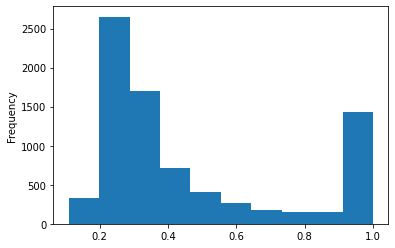

In [40]:
sub['target'].plot.hist()

In [50]:
df_1 = pd.read_csv('EXP_202_SWIN_128.csv').dropna(subset='pred')

In [51]:
df_2 = pd.read_csv('EXP_202_SWIN_64.csv').dropna(subset='pred')

In [52]:
roc_auc_score(df_1['target'], (df_1['pred'] + df_2['pred'])/2)

0.7273997490209775

In [33]:
#fns = list(Path('EXP_200_BASELINE_CASHE_V6_256_64').glob("*.pth"))
#fns = ["EXP_200_BASELINE_CASHE_V5_256/EXP_200_BASELINE_CASHE_V5_256_swin_large_patch4_window12_384_0_4.pth"]
#"EXP_200_BASELINE_CASHE_V5_256/EXP_200_BASELINE_CASHE_V5_256_swin_large_patch4_window12_384_0_6.pth",
#"EXP_200_BASELINE_CASHE_V5_256/EXP_200_BASELINE_CASHE_V5_256_swin_large_patch4_window12_384_0_9.pth" 
    # ]
fns = ["EXP_200_BASELINE_CASHE_V6_256_64/EXP_200_BASELINE_CASHE_V6_256_64_swin_large_patch4_window12_384_0_4.pth"]

fns

['EXP_200_BASELINE_CASHE_V6_256_64/EXP_200_BASELINE_CASHE_V6_256_64_swin_large_patch4_window12_384_0_4.pth']

In [34]:
#predict train

for mw in fns:
    print('_______')
    print(mw)
    df_eval = pd.read_csv('../../val/v21v.csv')
    df_eval.id = df_eval.id.apply(lambda x: Path(f"../../val/v21_val/{x}.pickle"))
    df_eval.columns = ['id', 'nonstationary_H1', 'nonstationary_L1', 'artifact_H1',
       'artifact_L1', 'freq', 'F1', 'F2', 'Alpha', 'Delta', 'h0', 'cosi', 'psi',
       'phi', 'snr', 'target', 'path']
    sub_ds = ValLoaderPickle(df_eval)
    vld_dl = DataLoader(
        sub_ds,
        batch_size=CFG.bs,
        shuffle=False,
        num_workers=CFG.nw,
        pin_memory=True,
        drop_last=False
    )


    custom_model = timm.create_model(
        CFG.model_name, pretrained=True, num_classes=1
    )

    custom_model.patch_embed = CustomHybdridEmbed(
        custom_model.patch_embed.proj, transformer_original_input_size=(1, 3, 384, 384)
    )


    custom_model.load_state_dict(torch.load(mw))
    custom_model.to("cuda:1");
    custom_model.eval();

    res = predict_tta(vld_dl, custom_model)
    df_eval['pred'] = torch.cat(res).view(-1).numpy()
    break
    df_eval['snr'] = df_eval['snr'].replace(np.nan, 0)
    df_eval = df_eval.dropna(subset='pred')
    dict_res = generate_report(df_eval)
    #dict_res_400_500 = generate_report(df_eval.query('freq>400 and freq<500'))
    #dict_res_300_400 = generate_report(df_eval.query('freq>300 and freq<400'))
    #dict_res_200_300 = generate_report(df_eval.query('freq>200 and freq<300'))
    #dict_res_50_200 = generate_report(df_eval.query('freq>50 and freq<200'))
    print('___all___')
    print(dict_res)
    #print('freq_400_500:')
    #print(dict_res_400_500)
    #print('freq_300_400:')
    #print(dict_res_300_400)
    #print('freq_200_300:')
    #print(dict_res_200_300)
    #print('freq_50_200:')
    #print(dict_res_50_200)



_______
EXP_200_BASELINE_CASHE_V6_256_64/EXP_200_BASELINE_CASHE_V6_256_64_swin_large_patch4_window12_384_0_4.pth


 10%|████████▍                                                                        | 13/125 [00:31<04:05,  2.19s/it]/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 13%|██████████▎                                                                      | 16/125 [00:37<03:58,  2.19s/it]/tmp/ipykernel_2720733/39500405.py:9: RuntimeWarning: invalid value encountered in true_divide
  data[1] = data[1] / data[1].mean()
 34%|███████████████████████████▊                                                     | 43/125 [01:37<03:00,  2.20s/it]/tmp/ipykernel_2720733/39500405.py:8: RuntimeWarning: invalid value encountered in true_divide
  data[0] = data[0] / data[0].mean()
 56%|█████████████████████████████████████████████▎                                   | 70/125 [02:36<02:01,  2.20s/it]/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWar

In [35]:
df_eval.id = df_eval.id.apply(lambda x: x.stem)
df_eval.to_csv('EXP_202_SWIN_64.csv', index=False)

In [ ]:
# 0.72128
# 0.7258

In [36]:
roc_auc_score(df_eval.dropna(subset='pred')['target'], df_eval.dropna(subset='pred')['pred'])

0.7212884322122955

In [55]:
x = pd.merge(pd.read_csv('EXP_202_SWIN_128_SUB.csv'), pd.read_csv('EXP_202_SWIN_64_SUB.csv'), on='id')

In [59]:
x['target'] =( x['target_x'] + x['target_y'])/2

In [62]:
x[['id', 'target']].to_csv('EXP_202_SWIN_756_INPUT.csv', index=False)